<a href="https://colab.research.google.com/github/d-maniatakos/vaccine-sentiment-classifier/blob/master/vaccine_sentiment_classifier_using_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Vaccine Sentiment Classifier using Feed-Forward Neural Networks**

## **Modules Import**

In [1]:
import pandas as pd
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader

import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, log_loss, confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, roc_auc_score
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## **Glove Download & Dictionary Creation**

In [2]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2021-12-16 17:56:01--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-12-16 17:56:02--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-12-16 17:56:02--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.5’

glove

In [3]:
glove = {}

# read file line by line while creating glove dictionary
with open('glove.6B.100d.txt') as f:
    lines = f.readlines()
for line in lines:
  vector = []
  for dim in line.split(' ')[1:]:
    vector.append(float(dim))
  glove[line.split(' ')[0]] = np.array(vector)

## **Data Import**

In [4]:
# read datasets and ignore the first (index) column
train_data =  pd.read_csv('vaccine_train_set.csv').iloc[:, 1:]
validation_data = pd.read_csv('vaccine_validation_set.csv').iloc[:, 1:]    # <--- replace with test set path

train_data.head()

,tweet,label
0,Sip N Shop Come thru right now #Marjais #Popul...,0
1,I don't know about you but My family and I wil...,1
2,@MSignorile Immunizations should be mandatory....,2
3,President Obama spoke in favor of vaccination ...,0
4,"""@myfoxla: Arizona monitoring hundreds for mea...",0


## **Pre-processing & Vectorization**

In [5]:
# preprocess tweets texts before vectorization
def preprocess(text):
  text = text.lower()
  unwanted_chars = ['@', '#', '!', '(', ')', '*', ':', ',']

  for char in unwanted_chars:
    text = text.replace(char, '')
  lemmatizer = WordNetLemmatizer()

  lemmatized_text = ''
  for word in text.split():
    lemmatized_text += lemmatizer.lemmatize(word) + ' '
  return lemmatized_text


# vectorize a tweet using glove word embedding
def glove_vectorize(corpus, representation = 'average', vector_size = 100):
  vectors = []
  for document in corpus:
    glove_vectors = []
    document_size = 0
    for token in document.split():
      try:
        glove_vectors.append(torch.from_numpy(glove[token]))
        document_size += 1
      except:
        pass

    try:
      if representation == 'average':
        vectors.append(torch.stack(glove_vectors, dim=0).sum(dim=0).div(document_size))
      elif representation == 'sum':
        vectors.append(torch.stack(glove_vectors, dim=0).sum(dim=0))
    except:
      vectors.append(torch.zeros(vector_size))
    
  return torch.stack(vectors, dim=0).to(torch.float32)


# create a tf-idf or bow vectorizer (using the training set's tweets)
def create_vectorizer(train_corpus, method='tf-idf', max_features=1000, ngram_range=(1, 2)):
  if method == 'tf-idf':
    vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)
  elif method == 'bow':
    vectorizer = CountVectorizer(max_features=max_features, ngram_range=ngram_range)
  return vectorizer.fit(train_corpus)

# vectorize a dataset
def vectorize(vectorizer, corpus):
  return torch.from_numpy(vectorizer.transform(corpus).toarray()).to(torch.float32)


# train_data['tweet'] = train_data['tweet'].apply(preprocess)
# validation_data['tweet'] = validation_data['tweet'].apply(preprocess)

train_corpus = train_data['tweet']
validation_corpus = validation_data['tweet']

## **First Model Creation & Training**


---

GloVe Word Embeddings and 3 Layers Neural Network


In [6]:
# use glove word embeddings
train_vector = glove_vectorize(train_corpus)
validation_vector = glove_vectorize(validation_corpus)

x_train = train_vector
y_train = torch.tensor(train_data['label'].values, dtype=torch.long)

x_validation = validation_vector
y_validation = torch.tensor(validation_data['label'].values, dtype=torch.long)

# neural network class
class NeuralNetwork1(nn.Module):
  def __init__(self, x_size, num_of_classes, hidden_layer1_size):
    super(NeuralNetwork1, self).__init__()

    self.layer1 = nn.Linear(x_size, hidden_layer1_size)
    self.layer2 = nn.ReLU()
    self.layer3 = nn.Linear(hidden_layer1_size, num_of_classes)

  def forward(self, x):
    out_1 = self.layer1(x)
    out_2 = self.layer2(out_1)
    out_3 = self.layer3(out_2)
    return out_3

# hyperparameters
input_size = 100
hidden_layer1_size = 50
output_size = 3
num_of_epochs = 20
batch_size = 200
learning_rate = 0.0005
loss_function = nn.CrossEntropyLoss()


model = NeuralNetwork1(input_size, output_size, hidden_layer1_size)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

training_loss = []
validation_loss = []

# training
for epoch in range(num_of_epochs):
  batch_losses = []

  for index, (x, y) in enumerate(train_dataloader):
    y_pred = model(x)
    loss = loss_function(y_pred, y)
    batch_losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  predictions = []


  y_pred_validation = model(x_validation)
  val_loss = loss_function(y_pred_validation, y_validation)

  
  print('Epoch: ' + str(epoch+1) + '/' + str(num_of_epochs) + ' Training Loss: ' + str(round(sum(batch_losses)/len(train_dataloader), 4)) + ' Validation Loss: ' + str(round(val_loss.item(), 4)))
  print('----------------------------------------------------------')
  training_loss.append((sum(batch_losses)/len(train_dataloader)))
  validation_loss.append(val_loss.item())

Epoch: 1/20 Training Loss: 0.9666 Validation Loss: 0.9312
----------------------------------------------------------
Epoch: 2/20 Training Loss: 0.9087 Validation Loss: 0.9026
----------------------------------------------------------
Epoch: 3/20 Training Loss: 0.8838 Validation Loss: 0.8839
----------------------------------------------------------
Epoch: 4/20 Training Loss: 0.8681 Validation Loss: 0.8723
----------------------------------------------------------
Epoch: 5/20 Training Loss: 0.8558 Validation Loss: 0.8637
----------------------------------------------------------
Epoch: 6/20 Training Loss: 0.8468 Validation Loss: 0.8611
----------------------------------------------------------
Epoch: 7/20 Training Loss: 0.8408 Validation Loss: 0.8514
----------------------------------------------------------
Epoch: 8/20 Training Loss: 0.8356 Validation Loss: 0.8514
----------------------------------------------------------
Epoch: 9/20 Training Loss: 0.8306 Validation Loss: 0.8441
------

## **First Model Evaluation**

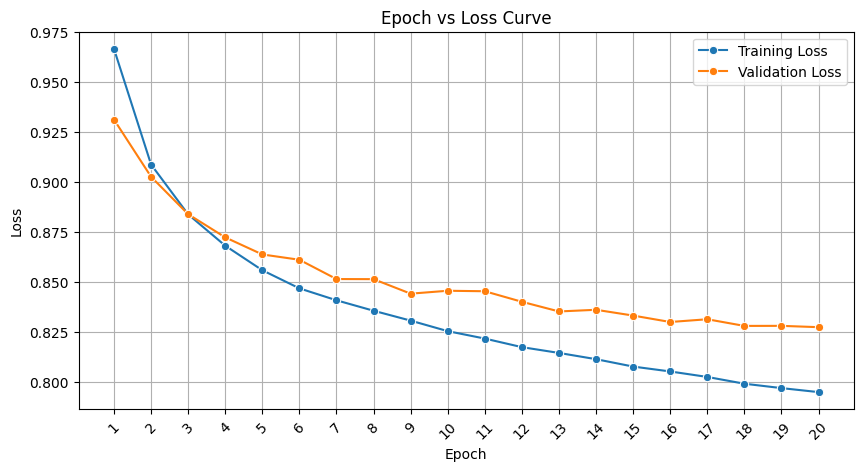

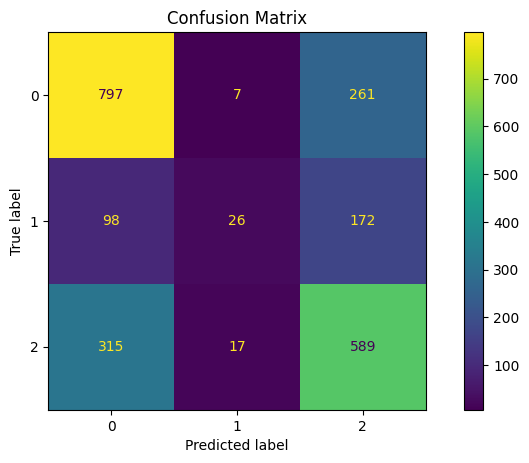

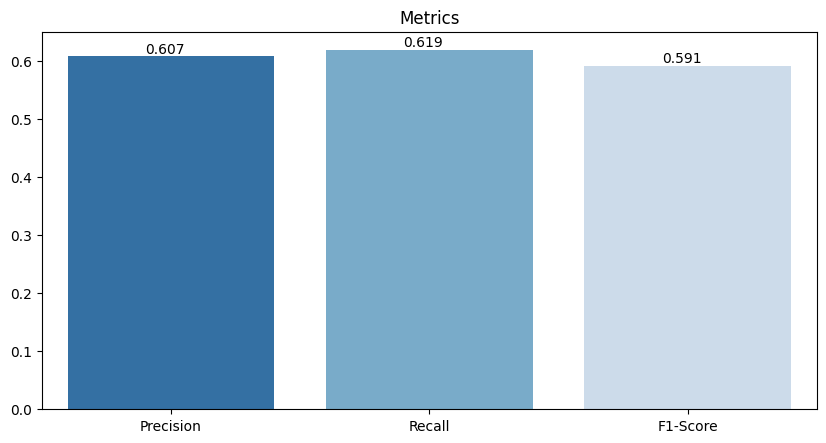

Precision: 0.6074510607644135
Recall: 0.6187554776511832
F1-Score: 0.5911790797354283


In [7]:
# make predictions about the validation set
predictions_scores = model(validation_vector)
predictions = torch.argmax(predictions_scores, dim=1).tolist()

precision = precision_score(y_validation.tolist(), predictions, average='weighted')
recall = recall_score(y_validation.tolist(), predictions, average='weighted')
f1 = f1_score(y_validation.tolist(), predictions, average='weighted')

# plot the epoch vs loss curve
plt.figure(figsize=(10, 5), dpi=100)
plt.title('Epoch vs Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
sns.lineplot(x=range(1, num_of_epochs+1), y=training_loss,  marker="o")
sns.lineplot(x=range(1, num_of_epochs+1), y=validation_loss,  marker="o")
plt.xticks(range(1, num_of_epochs+1))
plt.xticks(rotation=45)
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.show()


# plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
plt.title('Confusion Matrix')
ConfusionMatrixDisplay.from_predictions(y_validation.tolist(), predictions, ax=ax)
plt.show()

# plot scores
plt.figure(figsize=(10, 5), dpi=100)
plt.title('Metrics')
sns.barplot(x=['Precision', 'Recall', 'F1-Score'], y=[precision, recall, f1], palette='Blues_r')
for index, value in enumerate([precision, recall, f1]):
    plt.text(index-0.1, value+0.005,str(round(value,3)))
plt.show()

print('Precision: ' + str(precision))
print('Recall: ' + str(recall))
print('F1-Score: ' + str(f1))

## **Second Model Creation & Training**

---

TF-IDF Vectorization and 3 Layers Neural Network

In [8]:
# use tf-idf vectorization approach
tf_idf_vectorizer = create_vectorizer(train_data['tweet'])
train_vector = vectorize(tf_idf_vectorizer, train_corpus)
validation_vector = vectorize(tf_idf_vectorizer, validation_corpus)

x_train = train_vector
y_train = torch.tensor(train_data['label'].values, dtype=torch.long)

x_validation = validation_vector
y_validation = torch.tensor(validation_data['label'].values, dtype=torch.long)

# neural network class
class NeuralNetwork2(nn.Module):
  def __init__(self, x_size, num_of_classes, hidden_layer1_size, hidden_layer2_size):
    super(NeuralNetwork2, self).__init__()
    self.layer1 = nn.Linear(x_size, hidden_layer1_size)
    self.layer2 = nn.ReLU()
    self.layer3 = nn.ReLU()
    self.layer4 = nn.Linear(hidden_layer2_size, num_of_classes)

  def forward(self, x):
    out_1 = self.layer1(x)
    out_2 = self.layer2(out_1)
    out_3 = self.layer3(out_2)
    out_4 = self.layer4(out_3)
    return out_4

# hyperparameters
input_size = 1000
hidden_layer1_size = 100
hidden_layer2_size = 100
output_size = 3
num_of_epochs = 15
batch_size = 100
learning_rate = 0.0002
loss_function = nn.CrossEntropyLoss()

model = NeuralNetwork2(input_size, output_size, hidden_layer1_size, hidden_layer2_size)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

training_loss = []
validation_loss = []
validation_predictions = []

# training
for epoch in range(num_of_epochs):
  batch_losses = []

  for index, (x, y) in enumerate(train_dataloader):
    y_pred = model(x)
    loss = loss_function(y_pred, y)
    batch_losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  predictions = []


  y_pred_validation = model(x_validation)
  val_loss = loss_function(y_pred_validation, y_validation)
  validation_predictions.append(torch.argmax(y_pred_validation, dim=1))

  
  print('Epoch: ' + str(epoch+1) + '/' + str(num_of_epochs) + ' Training Loss: ' + str(round(sum(batch_losses)/len(train_dataloader), 4)) + ' Validation Loss: ' + str(round(val_loss.item(), 4)))
  print('----------------------------------------------------------')
  training_loss.append((sum(batch_losses)/len(train_dataloader)))
  validation_loss.append(val_loss.item())

Epoch: 1/15 Training Loss: 1.0235 Validation Loss: 0.9184
----------------------------------------------------------
Epoch: 2/15 Training Loss: 0.8455 Validation Loss: 0.8005
----------------------------------------------------------
Epoch: 3/15 Training Loss: 0.7526 Validation Loss: 0.7459
----------------------------------------------------------
Epoch: 4/15 Training Loss: 0.703 Validation Loss: 0.7185
----------------------------------------------------------
Epoch: 5/15 Training Loss: 0.6727 Validation Loss: 0.7018
----------------------------------------------------------
Epoch: 6/15 Training Loss: 0.6519 Validation Loss: 0.6922
----------------------------------------------------------
Epoch: 7/15 Training Loss: 0.6373 Validation Loss: 0.6843
----------------------------------------------------------
Epoch: 8/15 Training Loss: 0.6258 Validation Loss: 0.6801
----------------------------------------------------------
Epoch: 9/15 Training Loss: 0.6169 Validation Loss: 0.677
--------

## **Second Model Evaluation**

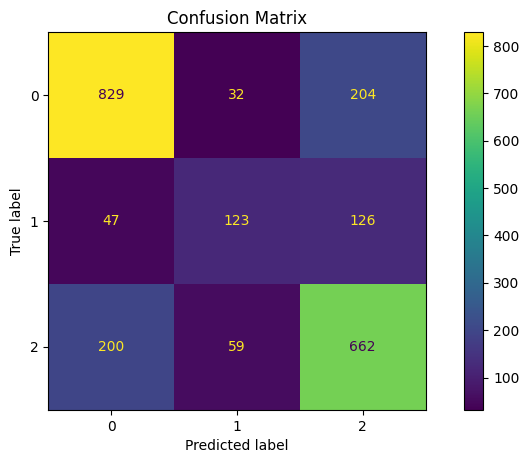

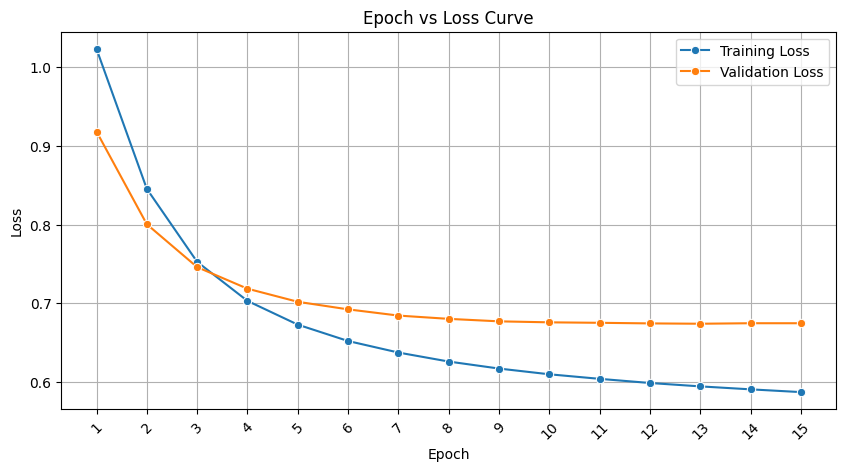

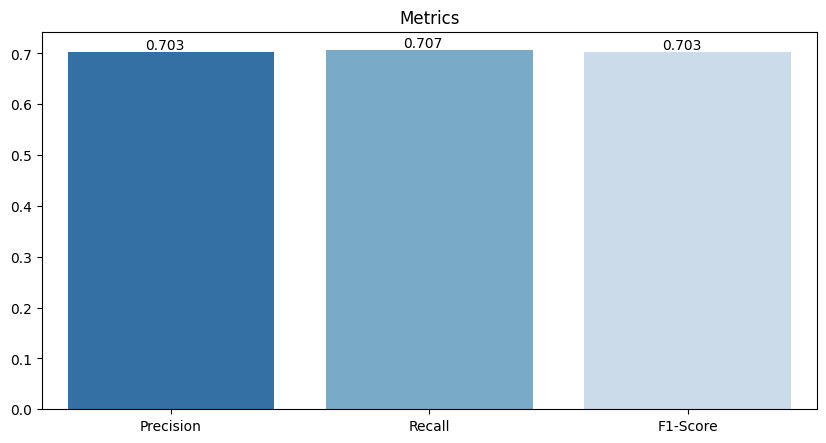

Precision: 0.7034508701451365
Recall: 0.7072743207712533
F1-Score: 0.7033073883654316


In [9]:
# make predictions about the validation set
predictions_scores = model(validation_vector)
predictions = torch.argmax(predictions_scores, dim=1).tolist()

precision = precision_score(y_validation.tolist(), predictions, average='weighted')
recall = recall_score(y_validation.tolist(), predictions, average='weighted')
f1 = f1_score(y_validation.tolist(), predictions, average='weighted')

# plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
plt.title('Confusion Matrix')
ConfusionMatrixDisplay.from_predictions(y_validation.tolist(), predictions, ax=ax)
plt.show()

# plot the epoch vs loss curve
plt.figure(figsize=(10, 5), dpi=100)
plt.title('Epoch vs Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
sns.lineplot(x=range(1, num_of_epochs+1), y=training_loss,  marker="o")
sns.lineplot(x=range(1, num_of_epochs+1), y=validation_loss,  marker="o")
plt.xticks(range(1, num_of_epochs+1))
plt.xticks(rotation=45)
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.show()

# plot scores
plt.figure(figsize=(10, 5), dpi=100)
plt.title('Metrics')
sns.barplot(x=['Precision', 'Recall', 'F1-Score'], y=[precision, recall, f1], palette='Blues_r')
for index, value in enumerate([precision, recall, f1]):
    plt.text(index-0.1, value+0.005,str(round(value,3)))
plt.show()

print('Precision: ' + str(precision))
print('Recall: ' + str(recall))
print('F1-Score: ' + str(f1))

## **ROC Curve**

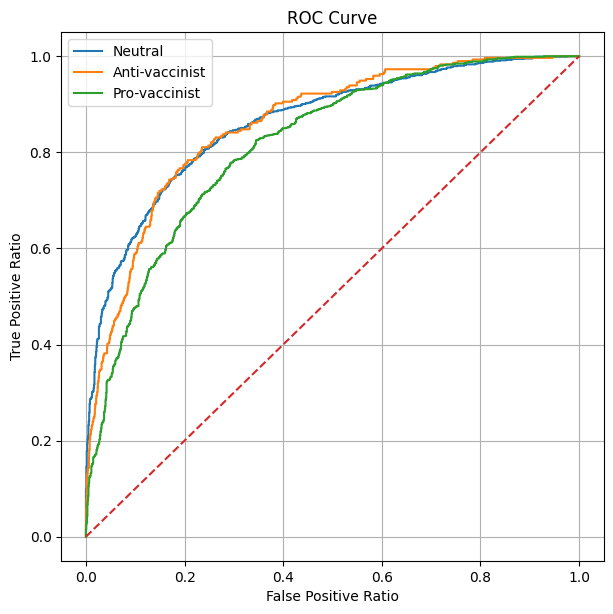

In [10]:
def plot_roc_curve():
  plt.figure(figsize=(7, 7), dpi=100)
  plt.grid()
  plt.xlabel('False Positive Ratio')
  plt.ylabel('True Positive Ratio')
  plt.title('ROC Curve')
  y_validation_binarized = label_binarize(y_validation, classes=[0, 1, 2])

  fpr, tpr, _ = roc_curve(y_validation_binarized[:, 0], [score[0] for score in predictions_scores.tolist()])
  plt.plot(fpr, tpr)

  fpr, tpr, _ = roc_curve(y_validation_binarized[:, 1], [score[1] for score in predictions_scores.tolist()])
  plt.plot(fpr, tpr)

  fpr, tpr, _ = roc_curve(y_validation_binarized[:, 2], [score[2] for score in predictions_scores.tolist()])
  plt.plot(fpr, tpr)

  #add a reference y=x line
  plt.plot([0, 1], [0, 1], linestyle='dashed')

  plt.legend(['Neutral', 'Anti-vaccinist', 'Pro-vaccinist'])

  plt.show()


plot_roc_curve()


## **Predictions**

In [11]:
# gets text and prints predicted sentiment
def predict_sentiment(text):
  text = preprocess(text)
  text_vector = vectorize(tf_idf_vectorizer, [text])
  prediction = model(text_vector)
  predicted_class = torch.argmax(prediction[0])
  if predicted_class == 0:
    print('Neutral Sentiment')
  elif predicted_class == 1:
    print('Anti-vaccinist')
  elif predicted_class == 2:
    print('Pro-vaccinist')


# some examples
predict_sentiment("Vaccines kill people")
predict_sentiment("I am in favour of vaccines, I believe they will help fight coronavirus")
predict_sentiment("The society is divided in this whole covid-19 pandemic")
predict_sentiment("I hate anti-vaccinists")
predict_sentiment("Vaccines are fake")
predict_sentiment("I cannot understand why people say vaccines are fake!")
predict_sentiment("Get your children vaccinated people!")

Anti-vaccinist
Pro-vaccinist
Neutral Sentiment
Pro-vaccinist
Anti-vaccinist
Anti-vaccinist
Pro-vaccinist
